#### 这是我们自己训练的用于速度反演 这个notebook是微震震源 的数据来反演速度 效果不是很好

In [1]:
import sys
sys.path.append('../neuralseismic/')
sys.path.append('..')
sys.path.append('./neuralseismic_xiao/')
sys.path.append('./neuralseismic_xiao/training/')  # Add this line to include the training module

from neuralseismic_xiao import FNO2d, equation_fd,equation_fd_conv,equation_fd_conv_8th,equation_fd_8th,equation_fd_4th,equation_fd_2th,equation_fft,equation_fd_4th
import torch
import scipy
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule
import numpy as np
from neuralop.models import FNO, UNO
from neuralseismic_xiao.CNOModule import CNO
plt.style.use(['science','notebook'])
device="cuda:1"

#### xinquan's weight

In [2]:
class LitModel(LightningModule):
    def __init__(self, input_channel=3, output_channel=2, mode_x=16, mode_y=16, width=64, nn_type='cno'):
        super().__init__()
        if nn_type == 'fno':
            #self.model = FNO2d(mode_x, mode_y, width, input_channel, output_channel)
            self.model = FNO(n_modes=(mode_x, mode_y),in_channels=input_channel, out_channels= output_channel, n_layers=4, hidden_channels=width,norm= 'group_norm')
        elif nn_type == 'cno':
            self.model = CNO(in_dim  = 3,      # Number of input channels.
                                    in_size = 128,                # Input spatial size
                                    N_layers = 5,                   # Number of (D) and (U) Blocks in the network
                                    N_res = 4,                         # Number of (R) Blocks per level
                                    N_res_neck =6,
                                    channel_multiplier =32,
                                    conv_kernel=3,
                                    cutoff_den = 2.0001,
                                    filter_size=6,  
                                    lrelu_upsampling = 2,
                                    half_width_mult  = 0.8,
                                    activation = 'lrelu')
        self.input_channel = input_channel

        self.save_hyperparameters()
        
    def forward(self, x):
        # Forward function that is run when visualizing the graph
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        # Main forward, loss computation, and metrics goes here
        x, y = batch
        # x, y = batch['x'], batch['y']
        y_hat = self.model(x[:,:self.input_channel])
        loss = self.loss_fn(y, y_hat)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # x, y = batch['x'], batch['y']
        x, y = batch
        y_hat = self.model(x[:,:self.input_channel])
        loss = self.loss_fn(y, y_hat)
        relative_err_real = calculate_relative_loss((y_hat-y)[:,0:1], y[:,0:1], reduction='mean')
        relative_err_imag = calculate_relative_loss((y_hat-y)[:,1:2], y[:,1:2], reduction='mean')
        self.log("val_loss", loss)
        self.log("val_relative_err_real", relative_err_real)
        self.log("val_relative_err_imag", relative_err_imag)

        
    def test_step(self, batch, batch_idx):
        # x, y = batch['x'], batch['y']
        x, y = batch
        y_hat = self.model(x[:,:self.input_channel])
        loss = self.loss_fn(y, y_hat)
        relative_err_real = calculate_relative_loss((y_hat-y)[:,0:1], y[:,0:1], reduction='mean')
        relative_err_imag = calculate_relative_loss((y_hat-y)[:,1:2], y[:,1:2], reduction='mean')
        self.log("test_loss", loss)
        self.log("test_relative_err_real", relative_err_real)
        self.log("test_relative_err_imag", relative_err_imag)

    def configure_optimizers(self,lr=1e-3, step_size=100, gamma=0.9):
        # Return one or several optimizers
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        scheduler = {'scheduler': torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma),
                     'interval': 'epoch',  # 或 'step' 对于每步更新
                     'frequency': 1}
        return [optimizer], [scheduler]

# xiao's weight
mode_x, mode_y, width, input_channel, output_channel = 48, 48, 256, 3, 2
model_network = LitModel(input_channel=input_channel, output_channel=2, mode_x=mode_x, mode_y=mode_y, width=width)

#'/home/max0b/neuroseismic/results_v9_8hz_cno/CurveAtest_9_8hz_cno_v2-2024-11-03-11-37-08/CurveAtest_9_8hz_cno_v2_sup_constantv.ckpt'这是用datav2训练的模型

# 加载 .ckpt 文件
ckpt_path = '/home/max0b/cno/seg2025/results_v9_10hz_picno_10_shots3_flip_lr1e-6_no_pde/CurveAtest_9_10hz_picno_10_shots2_flip_lr1e-6_no_pde-2025-02-17-14-18-55/checkpoints/epoch=109-step=11000.ckpt'
checkpoint = torch.load(ckpt_path,map_location='cpu')
# 提取模型的 state_dict
state_dict = checkpoint['state_dict']


# #model = FNO2d(mode_x, mode_y, width, input_channel, output_channel)
# #model.load_state_dict(torch.load('../data/model_fno_curveA.pth'))
model_network.load_state_dict(state_dict)
model_network.eval()

LitModel(
  (model): CNO(
    (lift): LiftProjectBlock(
      (inter_CNOBlock): CNOBlock(
        (convolution): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LReLu_regular(
          (activation): LeakyReLU(negative_slope=0.01)
        )
      )
      (convolution): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (project): LiftProjectBlock(
      (inter_CNOBlock): CNOBlock(
        (convolution): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LReLu_regular(
          (activation): LeakyReLU(negative_slope=0.01)
        )
      )
      (convolution): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (encoder): ModuleList(
      (0): CNOBlock(
        (convolution): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): 

In [3]:
# model_network = FNO2d(mode_x, mode_y, width, input_channel, output_channel)
# model_network.load_state_dict(torch.load('/home/max0b/neuroseismic/model_fno_curveA.pth'))

In [4]:
# Defination of the TV regularization loss
def tv_loss(model):
    h, w = model.shape 
    a = torch.pow(model[:h - 1, :w - 1] - model[1:, :w - 1],2)
    b = torch.pow(model[:h - 1, :w - 1] - model[:h - 1, 1:],2)
    #   penalize horizontal variations more than vertical
    return torch.sum(torch.pow(b +  a + 1e-15, 0.5))/(h*w)

In [5]:
#====================data_v2======================#
data_sample = np.load('/data/max0b/dataset_constant_v_10shots_10Hz_flip_v2/data_test.npy')
label= np.load("/data/max0b/dataset_constant_v_10shots_10Hz_flip_v2/label_test.npy")
#==================out_of_distribution==================#
# data_sample = np.load('/home/max0b/neuroseismic/data_train_v9/data_8hz_CurveVel_Fault_numpy/data.npy')
# label= np.load("/home/max0b/neuroseismic/data_train_v9/data_8hz_CurveVel_Fault_numpy/label.npy")

In [6]:
data_sample.shape,label.shape

((1200, 3, 128, 128), (1200, 2, 128, 128))

#### [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 61, 63, 64, 66, 68, 72, 73, 79, 81, 87, 92, 94, 98, 120, 121, 123, 125, 126, 127, 129, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 149, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 211, 216, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 273, 277, 280, 282, 284, 285, 287, 291, 294, 304, 310, 312, 315, 317, 319, 320, 324, 326, 331, 333, 336, 340, 341, 342, 343, 347, 349, 350, 352, 353, 354, 355, 356, 357, 358, 359, 360, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 415, 419, 420, 421, 425, 434, 436, 440, 441, 445, 446, 447, 449, 452, 456, 459, 460, 462, 463, 464, 465, 467, 468, 469, 471, 473, 474, 475, 478, 482, 523, 529, 539, 540, 544, 545, 565, 571, 572, 573, 574, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 670, 671, 672, 673, 675, 677, 678, 679, 680, 681, 682, 683, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 724, 730, 731, 732, 733, 734, 737, 738, 744, 745, 747, 748, 770, 773, 774, 775, 778, 782, 785, 786, 787, 791, 798, 799, 832, 834, 837, 871, 884, 893, 900, 902, 909, 910, 911, 912, 913, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 934, 939, 940, 941, 942, 943, 944, 945, 946, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1013, 1016, 1020, 1021, 1022, 1023, 1025, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1080, 1081, 1082, 1083, 1084, 1086, 1087, 1088, 1089, 1090, 1092, 1093, 1094, 1095, 1096, 1098, 1101, 1107, 1108, 1110, 1111, 1113, 1114, 1115, 1118, 1119, 1120, 1122, 1124, 1126, 1127, 1130, 1138, 1139, 1145, 1149, 1161, 1162, 1166, 1171, 1173, 1175, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1190, 1191, 1192, 1193, 1195, 1196, 1197, 1198, 1199] 

In [7]:
q=357#304 357

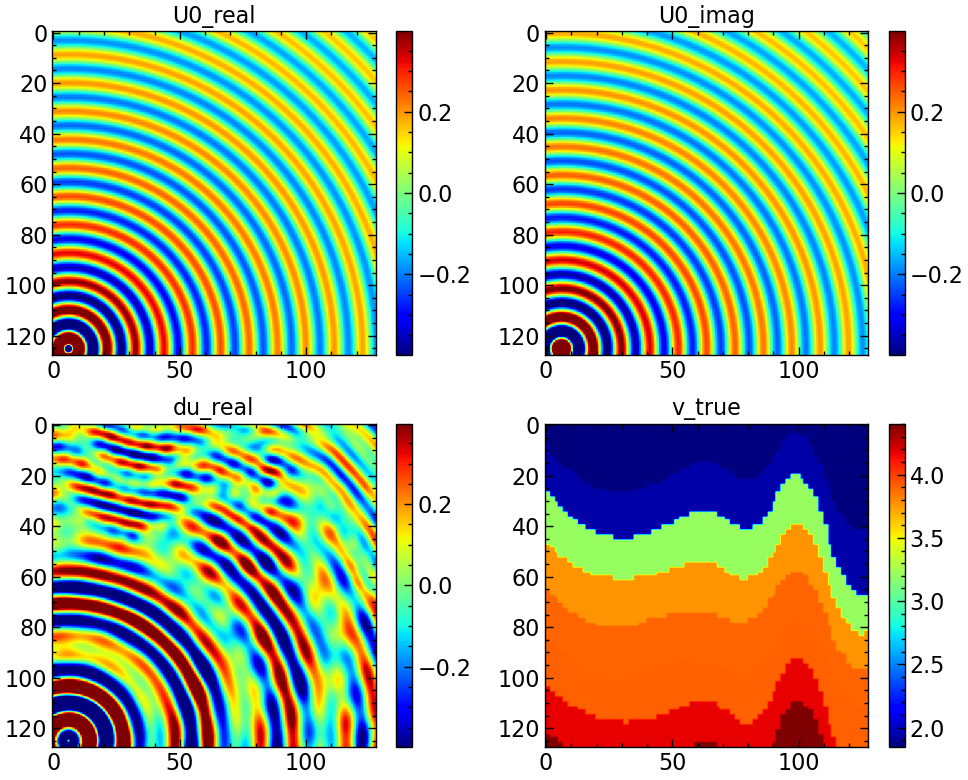

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一个包含2行2列的子图布局
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
vm = np.percentile(data_sample[q,0], 99)

# 在第一个子图上绘制 u0_real
im1 = axs[0, 0].imshow(data_sample[q,0], vmin=-vm, vmax=vm, cmap='jet')
axs[0, 0].set_title("U0_real")
fig.colorbar(im1, ax=axs[0, 0])  # 添加 colorbar

# 在第二个子图上绘制 du_real_pred
im2 = axs[0, 1].imshow(data_sample[q,1], vmin=-vm, vmax=vm, cmap='jet')
axs[0, 1].set_title("U0_imag")
fig.colorbar(im2, ax=axs[0, 1])  # 添加 colorbar

# 在第三个子图上绘制 du_real
im3 = axs[1, 0].imshow(label[q,0], vmin=-vm, vmax=vm, cmap='jet')
axs[1, 0].set_title('du_real')
fig.colorbar(im3, ax=axs[1, 0])  # 添加 colorbar

im4 = axs[1, 1].imshow(data_sample[q,2], cmap='jet')
axs[1, 1].set_title('v_true')
fig.colorbar(im4, ax=axs[1, 1])  # 添加 colorbar
# 调整布局，避免子图之间重叠
plt.tight_layout()

In [9]:
# inputs[0,0].min(),inputs[0,0].max(),inputs[0,0].mean(),inputs[0,0].std()

In [10]:
inputs = torch.tensor(data_sample[q][:3])
print(inputs.shape)
model_network=model_network.to(device)
inputs=inputs.unsqueeze(0).to(torch.float32)
print(inputs.shape)
print(inputs.dtype)
y_hat = model_network(inputs[:,:3].to(device))

torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.float32


In [11]:
outputs=y_hat.squeeze().cpu().detach().numpy()
print(outputs.shape)

(2, 128, 128)


(128, 128)
(128, 128)


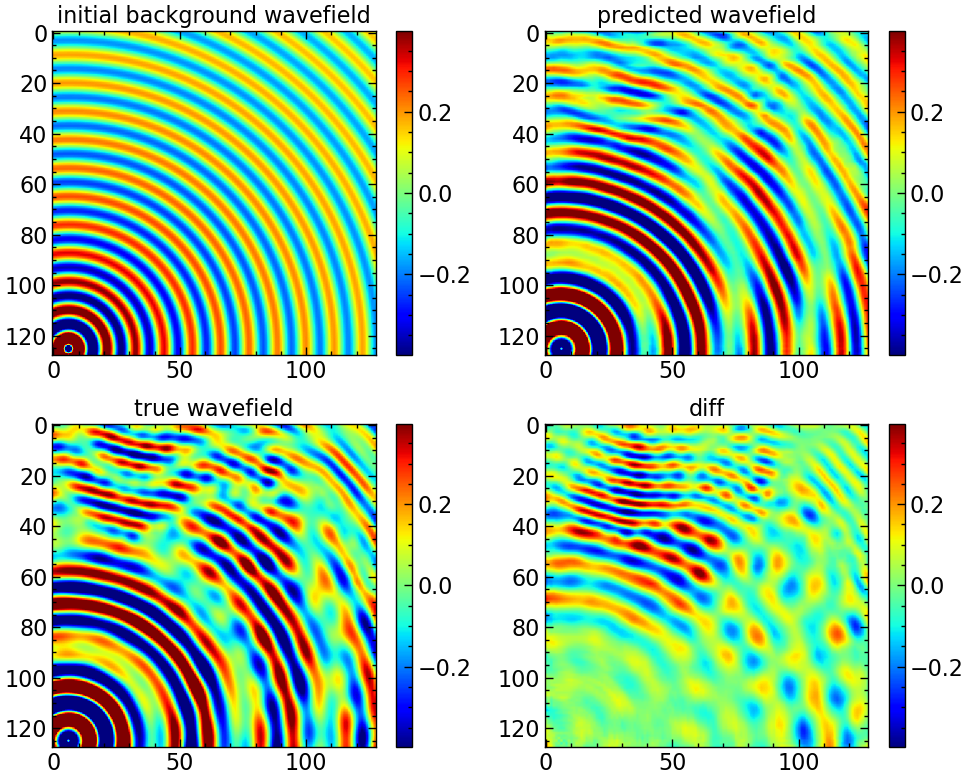

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一个包含2行2列的子图布局
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
vm = np.percentile(inputs[0,0], 99)

# 在第一个子图上绘制 u0_real
im1 = axs[0, 0].imshow(inputs[0,0], vmin=-vm, vmax=vm, cmap='jet')
axs[0, 0].set_title("initial background wavefield")
fig.colorbar(im1, ax=axs[0, 0])  # 添加 colorbar

# 在第二个子图上绘制 du_real_pred
im2 = axs[0, 1].imshow(outputs[0], vmin=-vm, vmax=vm, cmap='jet')
axs[0, 1].set_title("predicted wavefield")
fig.colorbar(im2, ax=axs[0, 1])  # 添加 colorbar

# 在第三个子图上绘制 du_real
im3 = axs[1, 0].imshow(label[q,0], vmin=-vm, vmax=vm, cmap='jet')
axs[1, 0].set_title('true wavefield')
fig.colorbar(im3, ax=axs[1, 0])  # 添加 colorbar
print(label[q,0].shape)
print(outputs[0].shape)
# 在第四个子图上绘制 du_real_diff
im4 = axs[1, 1].imshow(label[q,0]-outputs[0], vmin=-vm, vmax=vm, cmap='jet')
axs[1, 1].set_title('diff')
fig.colorbar(im4, ax=axs[1, 1])  # 添加 colorbar

# 调整布局，避免子图之间重叠
plt.tight_layout()

In [13]:
# Initialize a list to store the relative L2 errors
relative_l2_errors = []

for q in range(0, data_sample.shape[0]):
    inputs = torch.tensor(data_sample[q][:3])
    model_network = model_network.to(device)
    model_network.eval()
    
    inputs = inputs.unsqueeze(0).to(torch.float32).to(device)
    y_hat = model_network(inputs[:, :3])
    
    outputs = y_hat.squeeze().cpu().detach().numpy()
    0.
    y_true = torch.tensor(label[q, 0]).to(device)
    y_pred = torch.tensor(outputs[0]).to(device)

    # Compute Relative L2 Error
    l2_error = torch.norm(y_pred - y_true, p=2) / torch.norm(y_true, p=2)

    # Store in list
    relative_l2_errors.append(l2_error.item())

# Convert to numpy array if needed
relative_l2_errors = np.array(relative_l2_errors)

In [14]:
relative_l2_errors.mean(),relative_l2_errors.std()

(0.33817222508251904, 0.20197455932293845)

In [392]:
# inputs = torch.tensor(data_sample[q][:3])
# print(inputs.shape)
# model_network2=model_network2.to(device)
# inputs=inputs.unsqueeze(0).to(torch.float32)
# print(inputs.shape)
# print(inputs.dtype)
# y_hat = model_network2(inputs[:,:3].to(device))
# outputs=y_hat.squeeze().cpu().detach().numpy()
# print(outputs.shape)

In [393]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 创建一个包含2行2列的子图布局
# fig, axs = plt.subplots(2, 2, figsize=(10, 8))
# vm = np.percentile(inputs[0,0], 99)

# # 在第一个子图上绘制 u0_real
# im1 = axs[0, 0].imshow(inputs[0,0], vmin=-vm, vmax=vm, cmap='jet')
# axs[0, 0].set_title("initial background wavefield")
# fig.colorbar(im1, ax=axs[0, 0])  # 添加 colorbar

# # 在第二个子图上绘制 du_real_pred
# im2 = axs[0, 1].imshow(outputs[0], vmin=-vm, vmax=vm, cmap='jet')
# axs[0, 1].set_title("predicted wavefield")
# fig.colorbar(im2, ax=axs[0, 1])  # 添加 colorbar

# # 在第三个子图上绘制 du_real
# im3 = axs[1, 0].imshow(label[q,0], vmin=-vm, vmax=vm, cmap='jet')
# axs[1, 0].set_title('true wavefield')
# fig.colorbar(im3, ax=axs[1, 0])  # 添加 colorbar
# print(label[q,0].shape)
# print(outputs[0].shape)
# # 在第四个子图上绘制 du_real_diff
# im4 = axs[1, 1].imshow(label[q,0]-outputs[0], vmin=-vm, vmax=vm, cmap='jet')
# axs[1, 1].set_title('diff')
# fig.colorbar(im4, ax=axs[1, 1])  # 添加 colorbar

# # 调整布局，避免子图之间重叠
# plt.tight_layout()

In [394]:
# import torch.nn as nn
# valid_indices = []
# for q in range(0, data_sample.shape[0]):
#     inputs = torch.tensor(data_sample[q][:3])
    
#     model_network = model_network.to(device)
#     model_network2 = model_network2.to(device)
    
#     inputs = inputs.unsqueeze(0).to(torch.float32)
    
#     y_hat = model_network(inputs[:,:3].to(device))
#     outputs = y_hat.squeeze().cpu().detach().numpy()
    
#     y_hat2 = model_network2(inputs[:,:3].to(device))
#     outputs2 = y_hat2.squeeze().cpu().detach().numpy()
    
#     y_true = torch.tensor(label[q,0]).to(device)
#     y_pred = torch.tensor(outputs[0]).to(device)
#     y_pred2 = torch.tensor(outputs2[0]).to(device)
    
#     mse_loss = nn.MSELoss()
    
#     loss = mse_loss(y_pred, y_true)
#     loss2 = mse_loss(y_pred2, y_true)
    
#     if (loss / loss2) > 3:
#         valid_indices.append(q)
# print(valid_indices)
    

In [395]:
# # 定义一个列表来存储满足条件的序号
# valid_indices = []

# # 遍历 q 的范围
# for q in range(0, data_sample.shape[0], 50):
#     inputs = torch.tensor(data_sample[q][:3])
#     model_network = model_network.to(device)
#     model_network.eval()
#     inputs = inputs.unsqueeze(0).to(torch.float32)
#     y_hat = model_network(inputs[:,:3].to(device))
#     outputs = y_hat.squeeze().cpu().detach().numpy()
#     y_true = torch.tensor(label[q,0]).to(device)
#     y_pred = torch.tensor(outputs[0]).to(device)
    
#     # 定义 MSELoss 函数
#     mse_loss = nn.MSELoss()
    
#     # 计算 MSE 损失
#     loss = mse_loss(y_pred, y_true)
    
#     # 检查损失是否小于 0.0005
#     if loss.item() < 0.003:
#         valid_indices.append(q)

# # 输出满足条件的序号
# print(valid_indices)

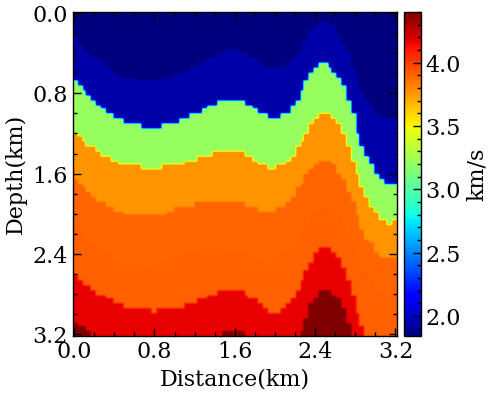

In [404]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,4))
#model_inver=init_v.detach().cpu().numpy().squeeze()
m_vmin, m_vmax=np.percentile(data_sample[q,2,...], [1,99]) 
im=plt.imshow(data_sample[q,2,...], vmin=m_vmin, vmax=m_vmax, cmap='jet', interpolation="bilinear")
colorbar=plt.colorbar(im, shrink=1, pad=0.01)
colorbar.set_label("km/s")
# Plot horizon with unique colors
cmap = plt.get_cmap('tab20')

# Plot horizon_initial with corresponding colors
# for i, (x, y) in enumerate(zip(inverse_x,inverse_z)):
#     color = color_map[i % len(color_map)]  # Ensures color cycling if horizon_initial is longer than color_map
#     plt.scatter(x, y, color=color, s=50, marker='o')
    
    
x_ticks = np.linspace(0, data_sample[q,2,...].shape[1]-1, 5)
x_label = [f'{num:.1f}' for num in np.linspace(0, 3.2, 5)]
y_ticks = np.linspace(0, data_sample[q,2,...].shape[0]-1, 5)
y_label = [f'{num:.1f}' for num in np.linspace(0, 3.2, 5)]
plt.tight_layout()
plt.xticks(x_ticks, x_label)
plt.yticks(y_ticks, y_label)
plt.xlabel("Distance(km)")
plt.ylabel("Depth(km)")
plt.savefig("/home/max0b/cno/seg2025/plot/10hz_velocity.pdf",dpi=500)

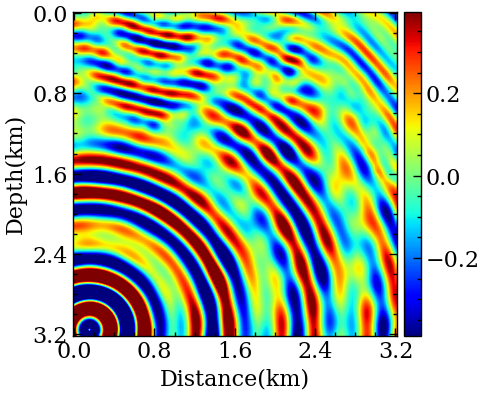

In [401]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8,4))
#model_inver=init_v.detach().cpu().numpy().squeeze()
m_vmin, m_vmax=np.percentile(inputs[0,0], [1,99]) 
im=plt.imshow(label[q,0], vmin=m_vmin, vmax=m_vmax, cmap='jet', interpolation="bilinear")
colorbar=plt.colorbar(im, shrink=1, pad=0.01)  # 调整shrink和pad参数
# colorbar.set_label("km/s", fontsize=14)
# colorbar.ax.tick_params(labelsize=12)  # Set the font size to 10
# Plot horizon with unique colors
cmap = plt.get_cmap('tab20')

# Plot horizon_initial with corresponding colors
# for i, (x, y) in enumerate(zip(inverse_x,inverse_z)):
#     color = color_map[i % len(color_map)]  # Ensures color cycling if horizon_initial is longer than color_map
#     plt.scatter(x, y, color=color, s=50, marker='o')
    
    
x_ticks = np.linspace(0, data_sample[q,2,...].shape[1]-1, 5)
x_label = [f'{num:.1f}' for num in np.linspace(0, 3.2, 5)]
y_ticks = np.linspace(0, data_sample[q,2,...].shape[0]-1, 5)
y_label = [f'{num:.1f}' for num in np.linspace(0, 3.2, 5)]
plt.tight_layout()
plt.xticks(x_ticks, x_label)
plt.yticks(y_ticks, y_label)
plt.xlabel("Distance(km)")
plt.ylabel("Depth(km)")
plt.savefig("/home/max0b/cno/seg2025/plot/10hz_label.pdf",dpi=500)

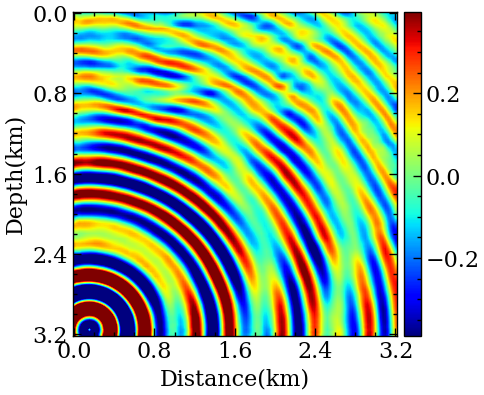

In [402]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8,4))
#model_inver=init_v.detach().cpu().numpy().squeeze()
m_vmin, m_vmax=np.percentile(inputs[0,0], [1,99]) 
im=plt.imshow(outputs[0], vmin=m_vmin, vmax=m_vmax, cmap='jet', interpolation="bilinear")
colorbar=plt.colorbar(im, shrink=1, pad=0.01)  # 调整shrink和pad参数
# colorbar.set_label("km/s", fontsize=14)
# colorbar.ax.tick_params(labelsize=12)  # Set the font size to 10
# Plot horizon with unique colors
cmap = plt.get_cmap('tab20')

# Plot horizon_initial with corresponding colors
# for i, (x, y) in enumerate(zip(inverse_x,inverse_z)):
#     color = color_map[i % len(color_map)]  # Ensures color cycling if horizon_initial is longer than color_map
#     plt.scatter(x, y, color=color, s=50, marker='o')
    
    
x_ticks = np.linspace(0, data_sample[q,2,...].shape[1]-1, 5)
x_label = [f'{num:.1f}' for num in np.linspace(0, 3.2, 5)]
y_ticks = np.linspace(0, data_sample[q,2,...].shape[0]-1, 5)
y_label = [f'{num:.1f}' for num in np.linspace(0, 3.2, 5)]
plt.tight_layout()
plt.xticks(x_ticks, x_label)
plt.yticks(y_ticks, y_label)
plt.xlabel("Distance(km)")
plt.ylabel("Depth(km)")
plt.savefig("/home/max0b/cno/seg2025/plot/10hz_scat_no.pdf",dpi=500)

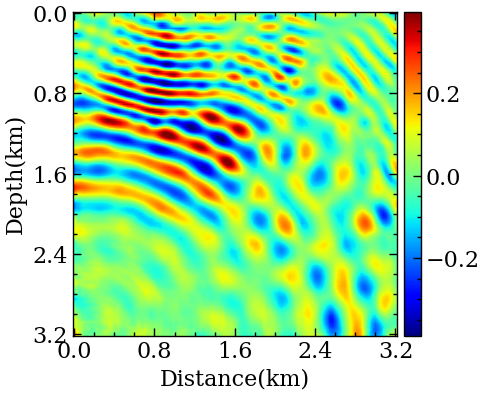

In [403]:

plt.figure(figsize=(8,4))
#model_inver=init_v.detach().cpu().numpy().squeeze()
m_vmin, m_vmax=np.percentile(inputs[0,0], [1,99]) 
im=plt.imshow(label[q,0]-outputs[0], vmin=m_vmin, vmax=m_vmax, cmap='jet', interpolation="bilinear")
colorbar=plt.colorbar(im, shrink=1, pad=0.01)  # 调整shrink和pad参数
# colorbar.set_label("km/s", fontsize=14)
# colorbar.ax.tick_params(labelsize=12)  # Set the font size to 10
# Plot horizon with unique colors
cmap = plt.get_cmap('tab20')

# Plot horizon_initial with corresponding colors
# for i, (x, y) in enumerate(zip(inverse_x,inverse_z)):
#     color = color_map[i % len(color_map)]  # Ensures color cycling if horizon_initial is longer than color_map
#     plt.scatter(x, y, color=color, s=50, marker='o')
    
    
x_ticks = np.linspace(0, data_sample[q,2,...].shape[1]-1, 5)
x_label = [f'{num:.1f}' for num in np.linspace(0, 3.2, 5)]
y_ticks = np.linspace(0, data_sample[q,2,...].shape[0]-1, 5)
y_label = [f'{num:.1f}' for num in np.linspace(0, 3.2, 5)]
plt.tight_layout()
plt.xticks(x_ticks, x_label)
plt.yticks(y_ticks, y_label)
plt.xlabel("Distance(km)")
plt.ylabel("Depth(km)")
plt.savefig("/home/max0b/cno/seg2025/plot/10hz_scat_no_diff.pdf",dpi=500)